In [87]:
# import dependencies

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import warnings
import random
import matplotlib.cm as cm

In [3]:
# grab our data from the csv file
df = pd.read_csv('CO2_emissions.csv')
df.shape

(20841, 11)

In [4]:
# To get an idea for which countries we should forecast, lets sort the countries in descending order with highest emission
# totals for the year 2020 since it's the most recent

df[df['year']==2020].sort_values(['co2'], ascending=False)[:10]

,iso_code,country,year,co2,co2_per_capita,co2_growth_prct,co2_growth_abs,cumulative_co2,share_global_co2,share_global_cumulative_co2,population
4061,CHN,China,2020,10667.887,7.412,1.70,177.899,235564.013,30.65,13.89,1.439324e+09
20024,USA,United States,2020,4712.771,14.238,-10.33,-543.046,416723.089,13.54,24.56,3.310026e+08
8747,IND,India,2020,2441.792,1.769,-7.01,-184.176,54416.489,7.02,3.21,1.380004e+09
15368,RUS,Russia,2020,1577.136,10.807,-6.09,-102.313,115344.150,4.53,6.80,1.459345e+08
9669,JPN,Japan,2020,1030.775,8.150,-6.80,-75.154,65625.167,2.96,3.87,1.264765e+08
8990,IRN,Iran,2020,745.035,8.870,1.59,11.669,18914.439,2.14,1.11,8.399295e+07
7397,DEU,Germany,2020,644.310,7.690,-9.43,-67.117,92635.615,1.85,5.46,8.378394e+07
15957,SAU,Saudi Arabia,2020,625.508,17.967,0.50,3.095,15936.377,1.80,0.94,3.481387e+07
17114,KOR,South Korea,2020,597.605,11.656,-7.78,-50.420,18335.707,1.72,1.08,5.126918e+07
8879,IDN,Indonesia,2020,589.500,2.155,-10.76,-71.094,14399.960,1.69,0.85,2.735236e+08


In [5]:
# Create a list to store the countries we will forecast from 2020 until 2050. Here we are simply taking the countries with 
# the highest total CO2 emissions for the year 2020 since they will likely be the largest influences in future CO2 emissions
country_list = list(df[df['year']==2020].sort_values(['co2'], ascending=False)[:10].country)
country_list

['China',
 'United States',
 'India',
 'Russia',
 'Japan',
 'Iran',
 'Germany',
 'Saudi Arabia',
 'South Korea',
 'Indonesia']

In [6]:
# Select the data for the USA, grab the year and CO2, set index to the year(type=int64), drop the name on the axis
#df = df[df['iso_code']=='USA']
#df = pd.DataFrame(df[['year','co2']]).dropna()

#df = df.set_index(['year'])
#df = df.rename_axis(None, axis=1)

In [7]:
# Select the last 100 years of data (training the model on more than that is unecessary)
#df = df[len(df)-100:]
#df.head()

In [8]:
# function to get the difference order for the ARIMA-model
def get_difference_order(country):
    
    # create new dataframe based on the one imported above and select only the data where country is equal to what
    # is entered into the function (this must be a string). Grab what is relevent (year, co2), reset the index to the year,
    df_n = df[df['country']== country]
    df_n = pd.DataFrame(df_n[['year', 'co2']])
    # removed 2020 since emissions were historically skewed due to COVID and confuses the model
    df_n = df_n[df_n['year']!=2020]
    df_n = df_n.set_index(['year'])
    df_n = df_n.rename_axis(None, axis=1)
    
    # used to get test statistics of our dataset. Here, result[1] is the p-value statistic. We don't want this to be too high
    # or too low (extremely low p-values actually produce more errors long term in our ARIMA model)
    result = adfuller(df_n)
    p_value = result[1]
    
    # set the difference order to 0
    d=0
    
    # while the p-value from above is greater than the upper threshold, iterate
    while p_value > 0.05:
        
        # take a difference and drop the null values
        df_n = df_n.diff().dropna()
        
        # re-evaluate our p-value after differencing using Dicky-Fuller test like before (adfuller())
        result = adfuller(df_n)
        p_value = result[1]
        
        
        # if the new p-value is below the bottom threshold, break the while loop
        if p_value <5e-7:
            break
        
        # else, add +1 to our difference order
        else:
            d+=1
    
    # return the difference order
    return(d)

In [9]:
def get_autoregressive_terms(country):
    
    # set an array of ar_terms to iterate through
    ar_terms = list(range(0,21))
    aic_values = []
    
    # get our difference order that was defined previously 
    d = get_difference_order(country)
    q = 1
    
    # reassign our new dataframe just like before
    df_n = df[df['country'] == country]
    df_n = pd.DataFrame(df_n[['year','co2']])
    # removed 2020 since emissions were historically skewed due to COVID and confuses the model
    df_n = df_n[df_n['year']!=2020]
    df_n = df_n.set_index(['year'])
    df_n = df_n.rename_axis(None, axis=1)
    
    # iterate through our possible ar_terms, here we set the maximum number as 20 for computational sake
    for p in range(len(ar_terms)):
        
        warnings.filterwarnings("ignore")
        model = ARIMA(df_n, order=(p,d,q))
        model_fit = model.fit()
        aic_values.append(model_fit.aic)
    
    min_aic = min(aic_values)
    p = ar_terms[aic_values.index(min_aic)]
    
    return(p)

In [10]:
def get_moving_avg_terms(country):
    
    
    ma_terms = list(range(1,10))
    aic_values = []
    
    # get our autoregressive_terms and difference_order
    p = get_autoregressive_terms(country)
    d = get_difference_order(country)
    
    # reassign our new dataframe just like before
    df_n = df[df['country'] == country]
    df_n = pd.DataFrame(df_n[['year','co2']])
    # removed 2020 since emissions were historically skewed due to COVID and confuses the model
    df_n = df_n[df_n['year']!=2020]
    df_n = df_n.set_index(['year'])
    df_n = df_n.rename_axis(None, axis=1)
    
    # iterate through our possible ar_terms, here we set the maximum number as 20 for computational sake
    for q in range(len(ma_terms)):
        
        warnings.filterwarnings("ignore")
        model = ARIMA(df_n, order=(p,d,q))
        model_fit = model.fit()
        aic_values.append(model_fit.aic)
    
    min_aic = min(aic_values)
    q = ma_terms[aic_values.index(min_aic)]
    
    return(q)

In [13]:
def arima_test(country):
    
    # Call our p,d,q from the previously defined functions that minimize AIC values
    p = get_autoregressive_terms(country)
    d = get_difference_order(country)
    q = get_moving_avg_terms(country)
    
    # reassign our new dataframe just like before
    df_n = df[df['country'] == country]
    df_n = pd.DataFrame(df_n[['year','co2']])
    # removed 2020 since emissions were historically skewed due to COVID and confuses the model
    df_n = df_n[df_n['year']!=2020]
    df_n = df_n.set_index(['year'])
    df_n = df_n.rename_axis(None, axis=1)
    
    # our CO2 emissions
    X = df_n.values
    
    # selecting a testing size (70% train, 30% test)
    size = int(len(X)*.75)
    
    # slices our original data into train,test sets
    train, test = X[0:size], X[size:len(X)]
    
    # stores our past values, initialized to hold the training set
    history = [x for x in train]
    
    # list to hold our model's predictions
    predictions = list()
    
    # iterate through our test data
    for t in range(len(test)):
    
        warnings.filterwarnings("ignore")

        # Fit the model to our initialzied data (training set) using (p,d,q) from the analysis above
        model = ARIMA(history, order=(p,d,q))

        # Fit the model
        model_fit = model.fit()

        # predict the next value based on the fitted model.
        output = model_fit.forecast()
        yhat = output[0]

        # add the prediction to our list of predictions
        predictions.append(yhat)
        
        obs = test[t]
        history.append(obs)
        
    # calculate our root mean squared error   
    rmse = np.sqrt(mean_squared_error(test, predictions))
    
    x = df_n.index[-len(test):].values
    plt.figure(figsize=(10,6),dpi=100)
    plt.plot(x, test, label='Actual')
    plt.plot(x,predictions, color='r', linestyle='--',label='ARIMA model')
    plt.title(f'Model Predictions vs Test ({country})')
    plt.xlabel('Year')
    plt.ylabel('CO2 Emissions')
    plt.legend()
    plt.grid()
    plt.show()
    print("RMSE: %.3f" % rmse)

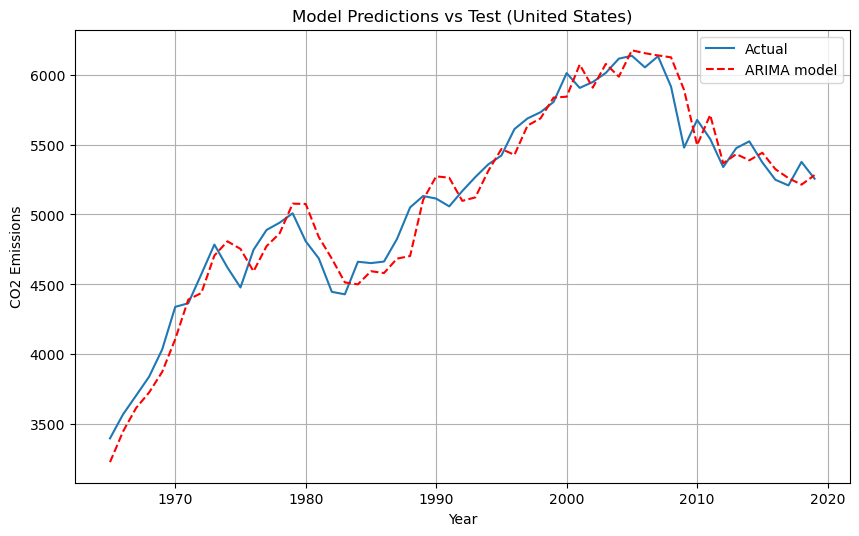

RMSE: 149.324


In [14]:
arima_test('United States')

In [73]:
forecast_df = pd.DataFrame()

In [74]:
def arima_forecast(country, forecast):
    
    # Call our p,d,q from the previously defined functions that minimize AIC values
    p = get_autoregressive_terms(country)
    d = get_difference_order(country)
    q = get_moving_avg_terms(country)
    
    
    # reassign our new dataframe just like before
    df_n = df[df['country'] == country]
    df_n = pd.DataFrame(df_n[['year','co2']])
    # removed 2020 since emissions were historically skewed due to COVID and confuses the model
    df_n = df_n[df_n['year']!=2020]
    df_n = df_n.set_index(['year'])
    df_n = df_n.rename_axis(None, axis=1)
    
    
    history = df_n.values
    predictions = list()
    model = ARIMA(history, order=(p,d,q))
    model_fit = model.fit()
    
    residuals = pd.DataFrame(model_fit.resid)
    mu = residuals.describe()[0][1]
    std = residuals.describe()[0][2]
    bias = np.random.normal(mu,std,forecast)
    
    for t in range(forecast):
        warnings.filterwarnings('ignore')
        model = ARIMA(history, order=(p,d,q))
        model_fit = model.fit()
        yhat = model_fit.forecast()[0] + bias[t]
        predictions.append(yhat)
        history = np.append(history,yhat)
    
    #x = list(range(df_n.index[-1],df_n.index[-1]+ int(forecast)))
    #plt.figure(figsize=(10,6),dpi=100)
    #plt.plot(df_n.index[:],history[:-forecast], color='red',label='Actual')
    #plt.plot(x,predictions,color='red', linestyle='--',label='Prediction')
    #plt.title(f'ARIMA forecast model ({country})')
    #plt.xlabel('Year')
    #plt.ylabel('CO2 Emissions')
    #plt.legend()
    #plt.grid()
    #plt.show()
    
    # grab the previous 30 years before forecasting, and the years that were forecasted as a list. This should be 1990-2050
    years = list(range(df_n.index[-forecast],df_n.index[-1]+forecast+1))
    emissions = history[-forecast*2:]
    

    forecast_df[country] = pd.DataFrame(emissions, index=years)

In [75]:
for country in country_list:
    arima_forecast(country, 31)

In [76]:
forecast_df

,China,United States,India,Russia,Japan,Iran,Germany,Saudi Arabia,South Korea,Indonesia
1989,2463.654000,5131.927000,541.135000,2400.308000,1021.682000,190.198000,1008.792000,203.424000,223.565000,131.674000
1990,2484.855000,5113.455000,578.518000,2525.518000,1158.007000,209.944000,1052.477000,208.497000,250.469000,150.285000
1991,2606.096000,5057.931000,615.925000,2396.205000,1169.692000,226.011000,1014.225000,288.545000,275.657000,180.621000
1992,2730.788000,5167.481000,656.033000,1957.886000,1179.396000,226.935000,965.893000,316.175000,300.033000,203.577000
1993,2921.651000,5267.343000,677.916000,1859.679000,1172.339000,235.607000,956.132000,340.642000,330.272000,219.762000
...,...,...,...,...,...,...,...,...,...,...
2046,17663.354492,6108.556952,7173.884411,2293.333343,858.284625,1236.210353,435.593223,741.802072,889.408541,1491.294206
2047,17854.948882,6082.551781,7431.317062,2286.559194,888.985443,1254.003712,459.755234,719.891338,905.348481,1528.460132
2048,17955.741545,6142.492764,7610.696708,2293.282035,834.699493,1287.289454,373.445690,735.992183,916.117598,1574.825289
2049,18092.829411,6348.515771,7876.342186,2259.746876,823.921789,1305.546687,442.041165,794.923420,923.588729,1622.282886


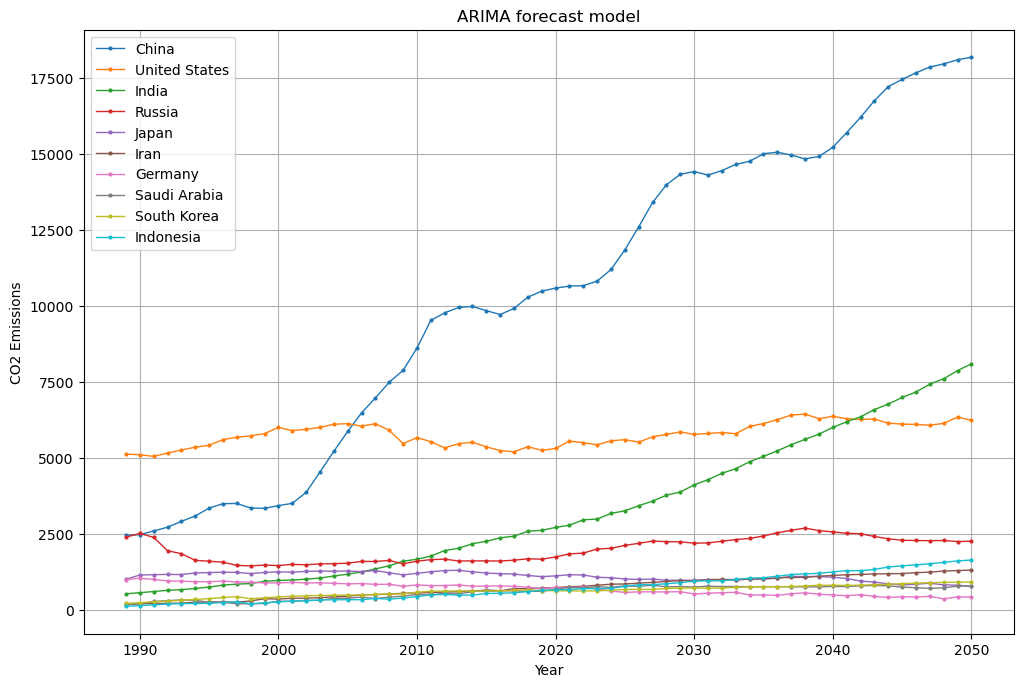

In [104]:
plt.figure(figsize=(12,8),dpi=100)
plt.plot(forecast_df.index[:], forecast_df.values,label=forecast_df.columns,linestyle='-',marker='o',linewidth=1,markersize=2)
plt.title('ARIMA forecast model')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.legend()
plt.grid()
plt.show()

In [105]:
forecast_df.to_csv('emissions_forecast.csv',index=False)